# Generative Adversarial Networks

### Imports

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from collections import defaultdict
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST

### MPS Settings

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device:', device)

Device: cuda


### Dataset Import

In [5]:
transform = transforms.ToTensor()
mnist = MNIST('.', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 8.31MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 382kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [6]:
dic = defaultdict(int)
for img in mnist:
    dic[img[1]] += 1

In [7]:
dic

defaultdict(int,
            {5: 5421,
             0: 5923,
             4: 5842,
             1: 6742,
             9: 5949,
             2: 5958,
             3: 6131,
             6: 5918,
             7: 6265,
             8: 5851})

Label: 5


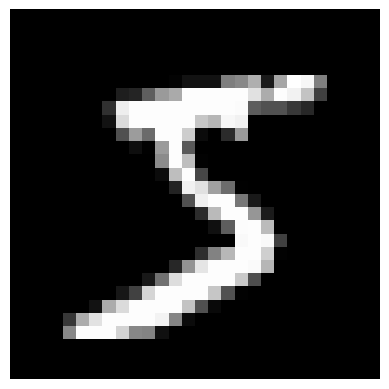

In [8]:
def show_image(tensor_img):
    img = tensor_img.squeeze().detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

print(f'Label: {mnist[0][1]}')
show_image(mnist[0][0])

In [9]:
train_loader = DataLoader(mnist, batch_size=64, shuffle=True, num_workers=4)

### Model Definition

In [10]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=1, feature_maps=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, feature_maps * 4 * 7 * 7),
            nn.BatchNorm1d(feature_maps * 4 * 7 * 7),
            nn.ReLU(True),
            
            nn.Unflatten(1, (feature_maps * 4, 7, 7)),

            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            nn.Conv2d(feature_maps, img_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_maps=64):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, feature_maps, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(feature_maps * 4 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.net(img)

### Model Initialization

In [11]:
latent_dim = 100

generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss().to(device)
optim_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

real_label = 1.
fake_label = 0.

### Training

In [ ]:
num_epochs = 30

for epoch in range(num_epochs):
    generator.train()
    running_loss_g = 0.0
    running_loss_d = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        batch_size = images.size(0)

        discriminator.zero_grad()
        labels = torch.full((batch_size,), real_label, device=images.device)
        output = discriminator(images).view(-1)
        loss_real = criterion(output, labels)
        loss_real.backward()

        noise = torch.randn(batch_size, latent_dim, device=images.device)
        fake_images = generator(noise)
        labels.fill_(fake_label)
        output = discriminator(fake_images.detach()).view(-1)
        loss_fake = criterion(output, labels)
        loss_fake.backward()
        optim_d.step()

        generator.zero_grad()
        labels.fill_(real_label)
        output = discriminator(fake_images).view(-1)
        loss_g = criterion(output, labels)
        loss_g.backward()
        optim_g.step()

        running_loss_g += loss_g.item()
        running_loss_d += (loss_real.item() + loss_fake.item())

    avg_loss_g = running_loss_g / len(train_loader)
    avg_loss_d = running_loss_d / (2 * len(train_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}]  Loss D: {avg_loss_d:.4f}  Loss G: {avg_loss_g:.4f}')

    if epoch % 2 == 0:
        generator.eval()
        with torch.no_grad():
            fixed_noise = torch.randn(1, latent_dim, device=images.device)
            fake_img = generator(fixed_noise).detach().cpu()
            show_image(fake_img)

In [ ]:
torch.save(generator.state_dict(), 'models/generator.pth')
torch.save(discriminator.state_dict(), 'models/discriminator.pth')

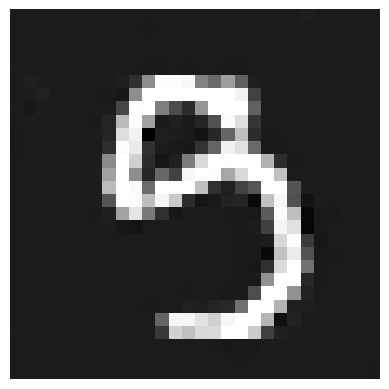

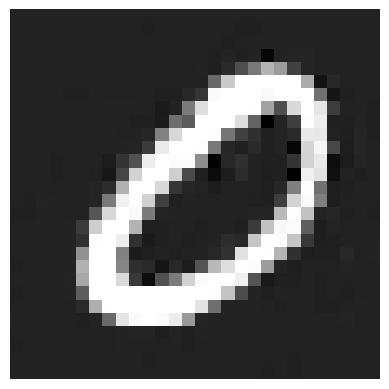

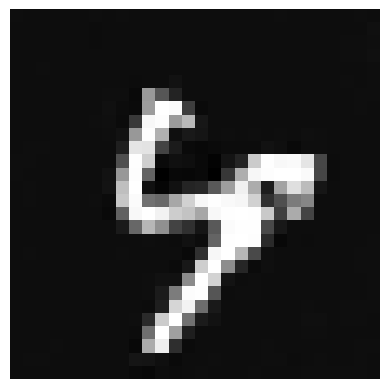

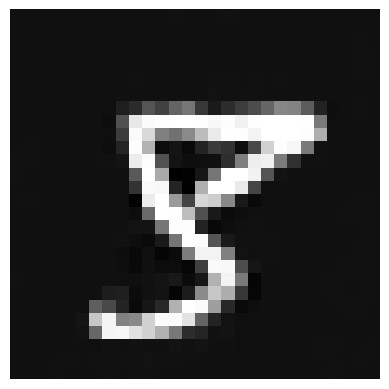

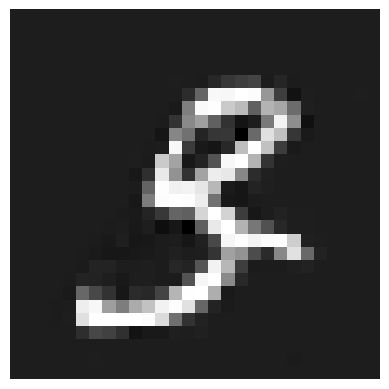

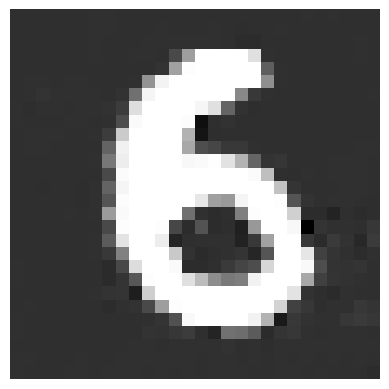

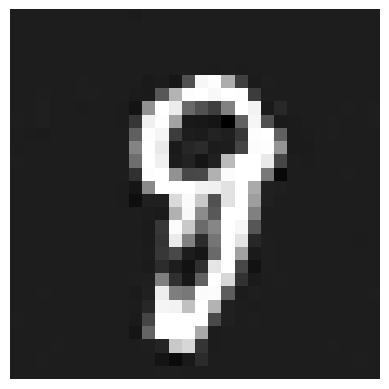

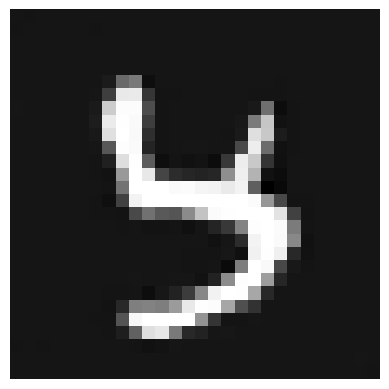

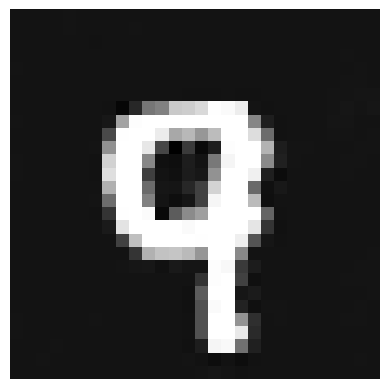

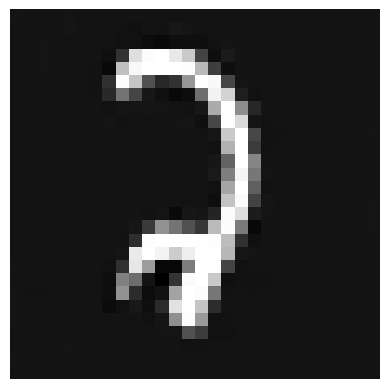

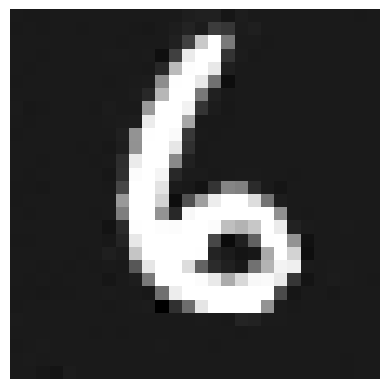

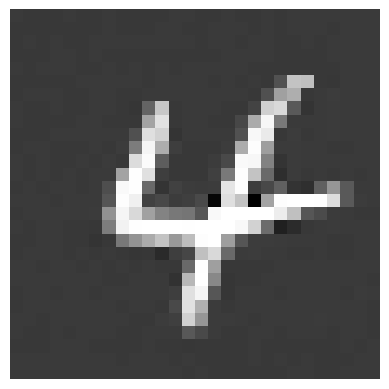

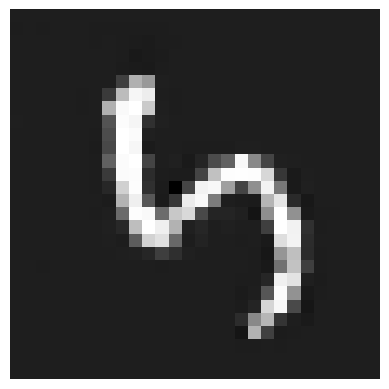

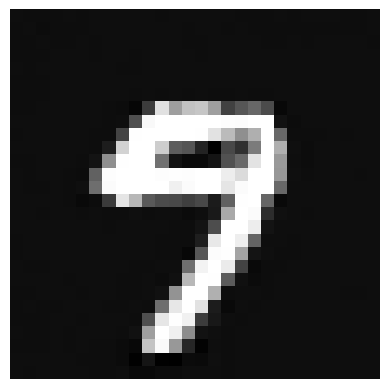

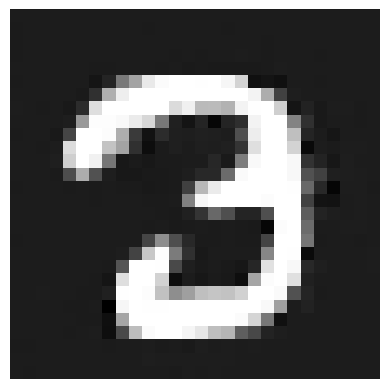

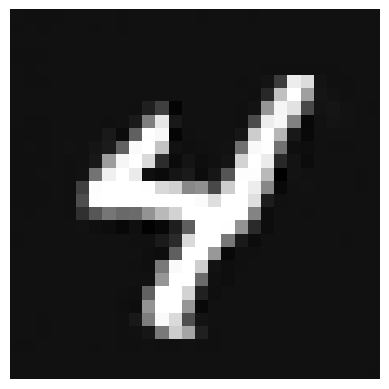

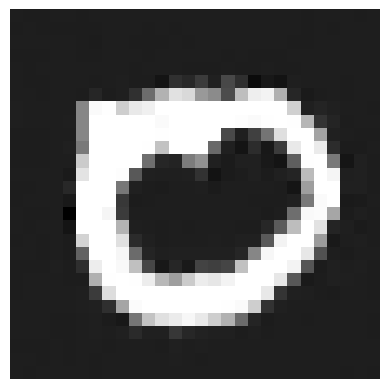

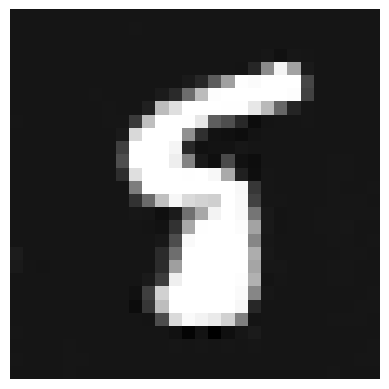

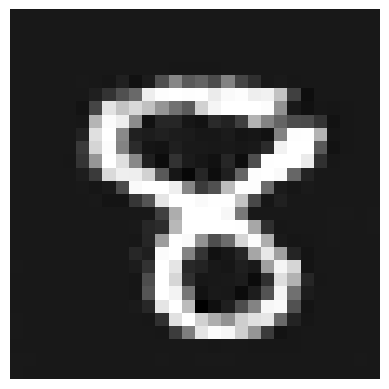

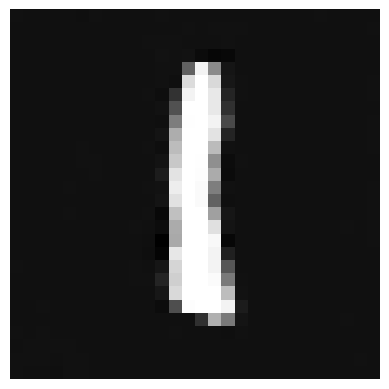

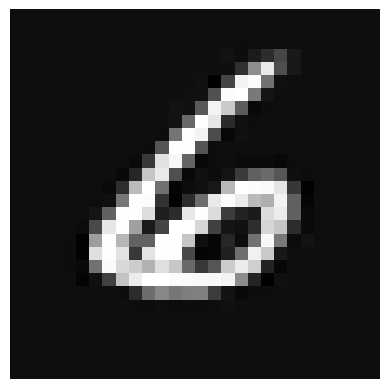

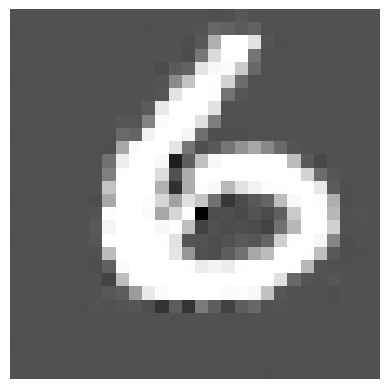

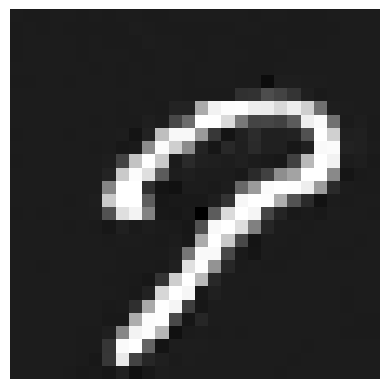

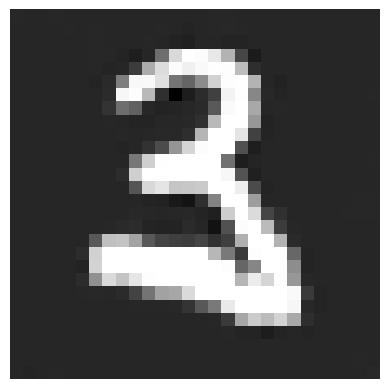

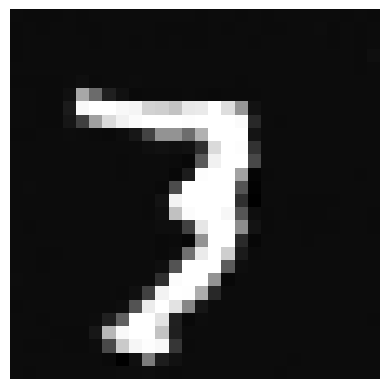

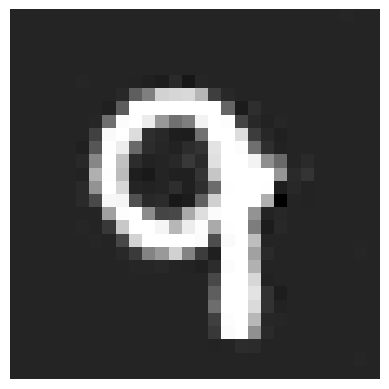

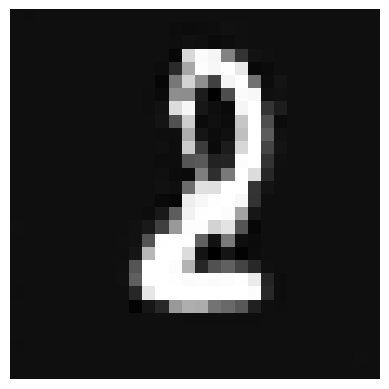

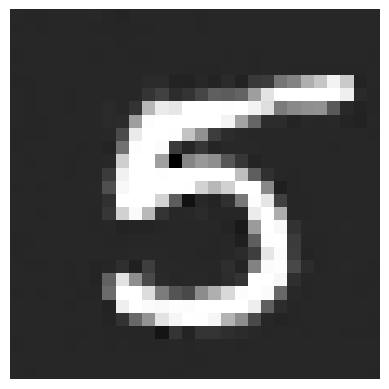

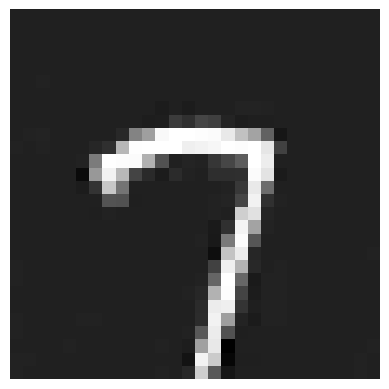

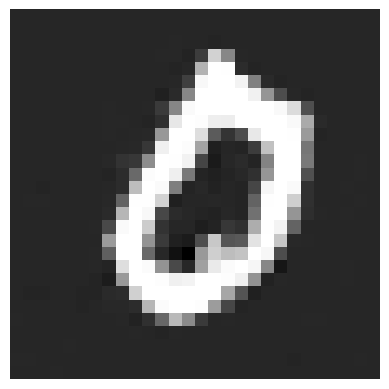

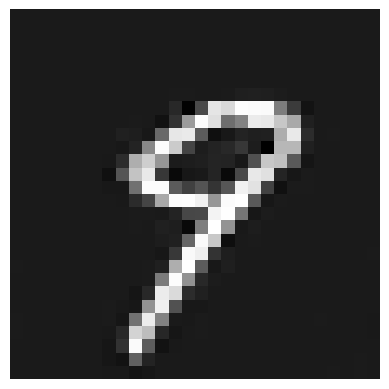

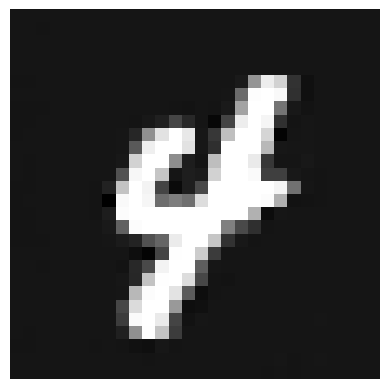

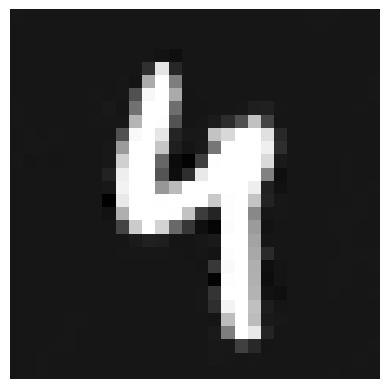

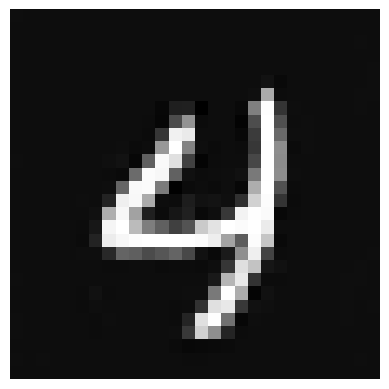

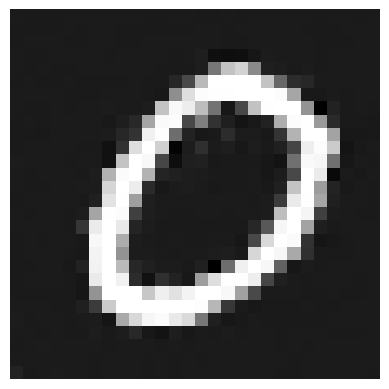

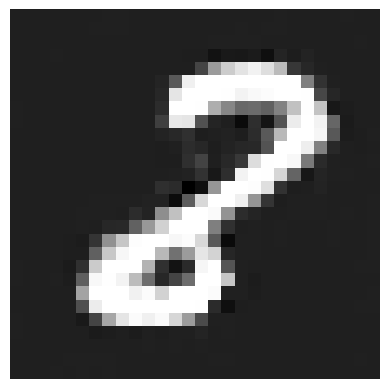

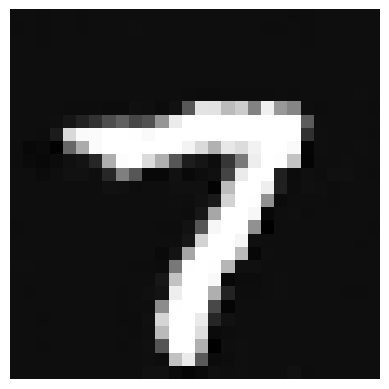

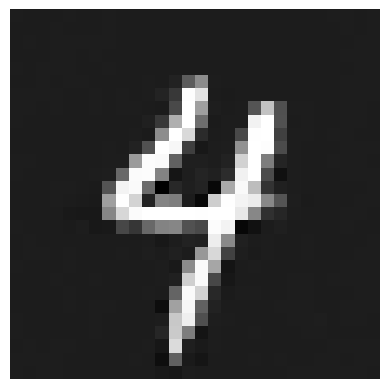

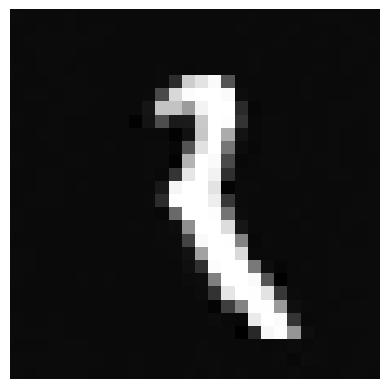

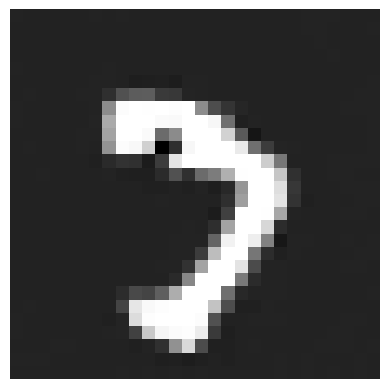

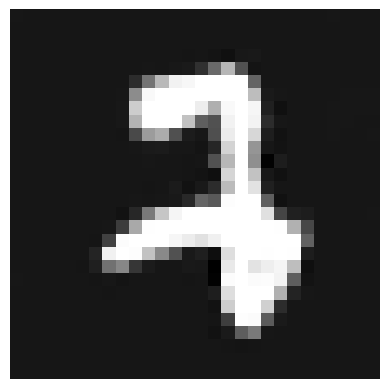

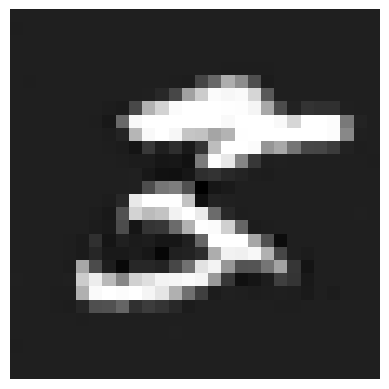

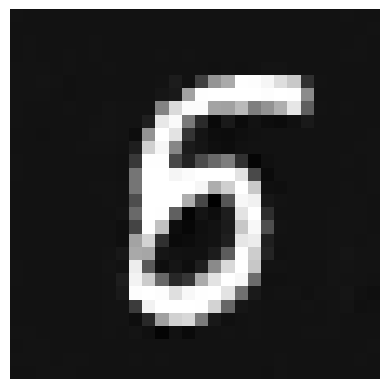

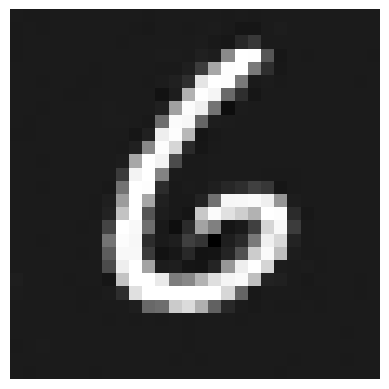

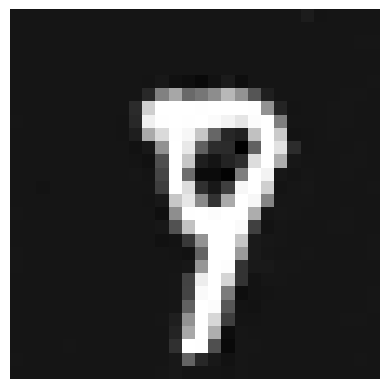

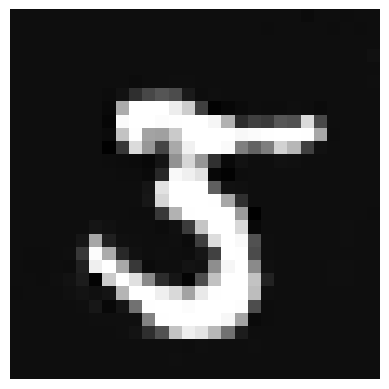

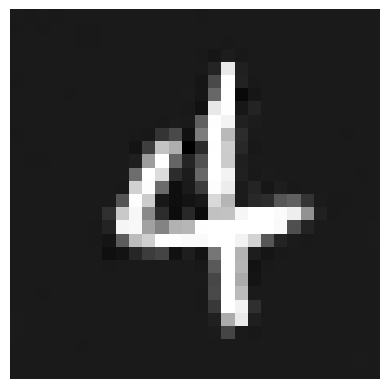

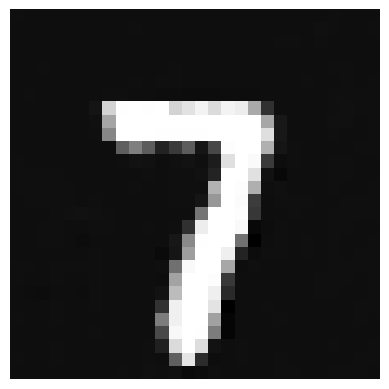

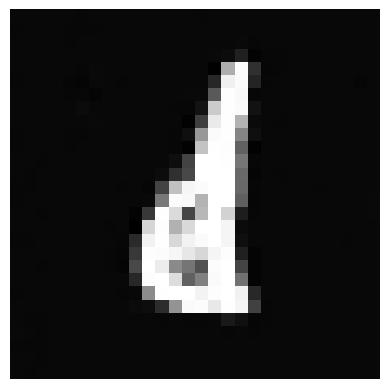

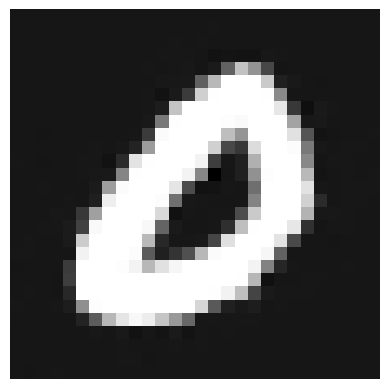

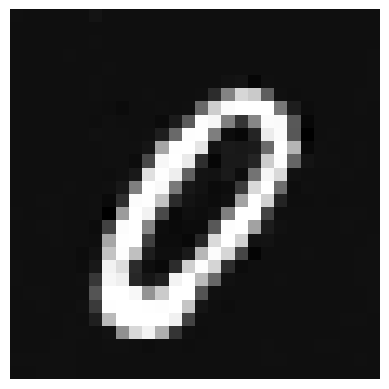

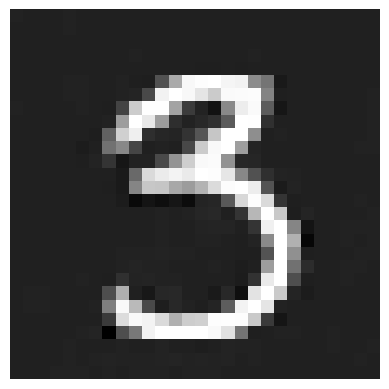

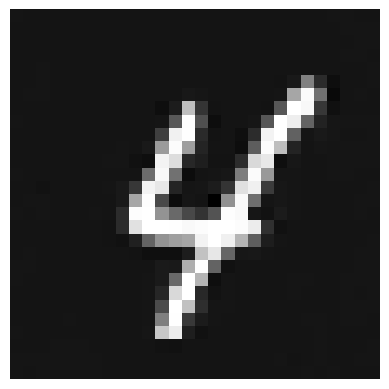

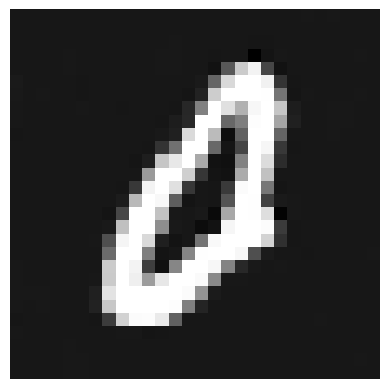

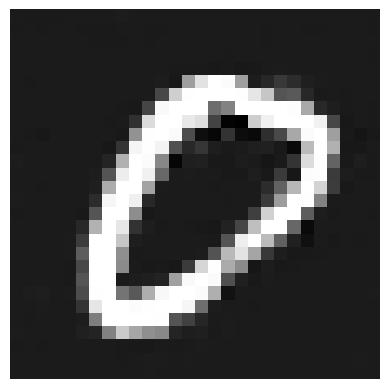

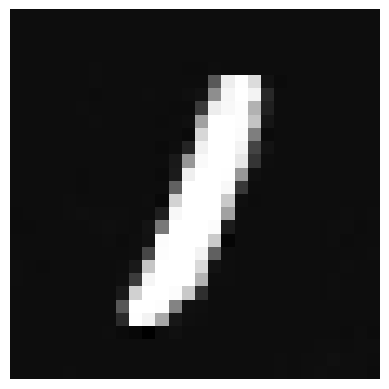

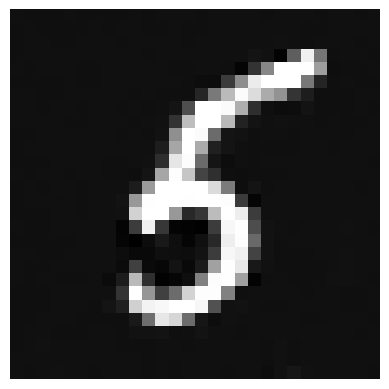

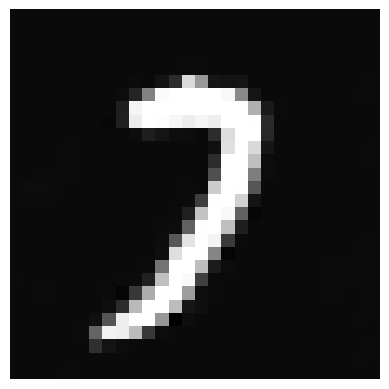

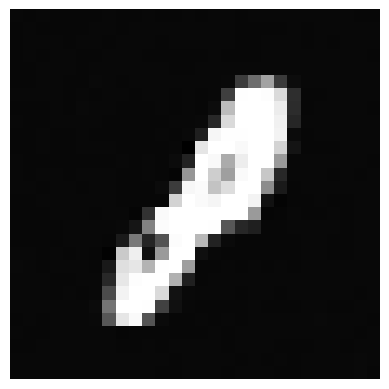

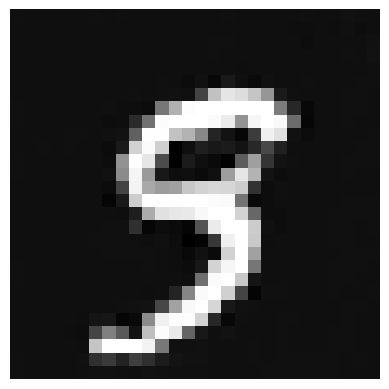

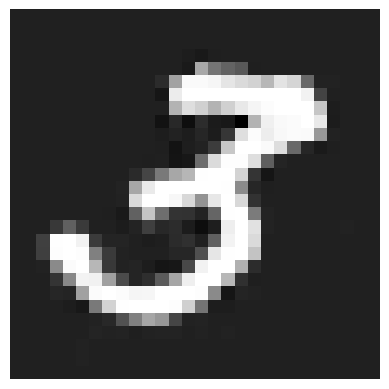

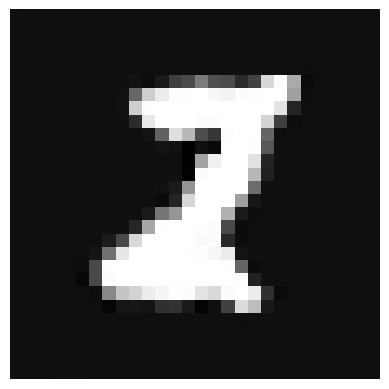

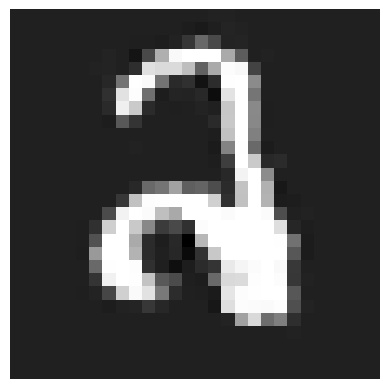

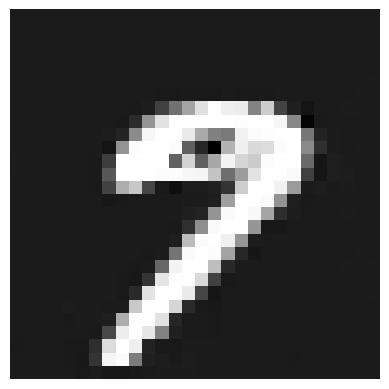

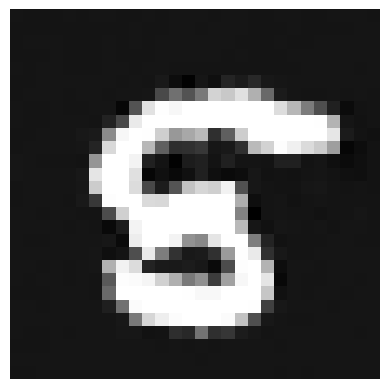

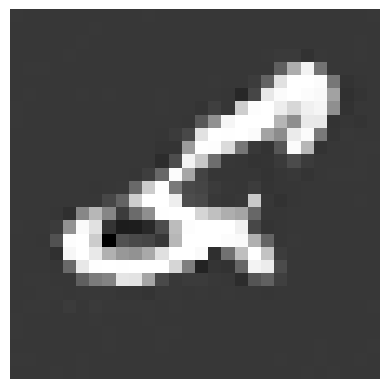

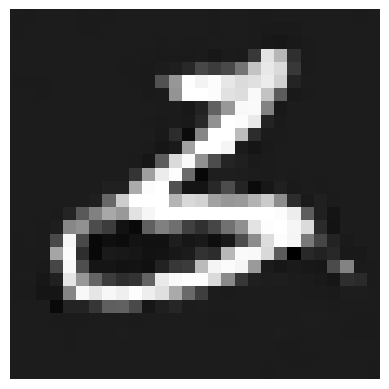

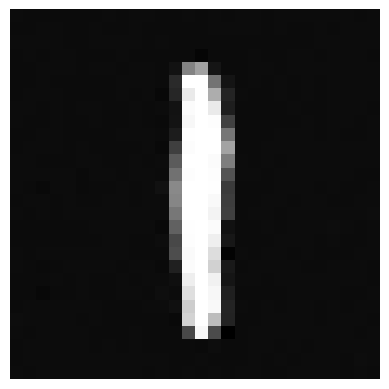

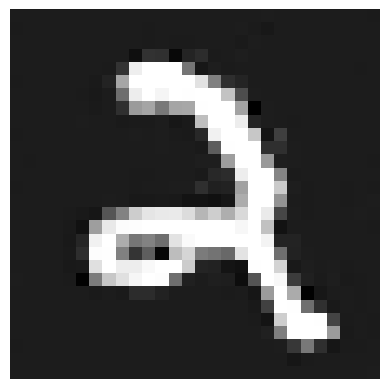

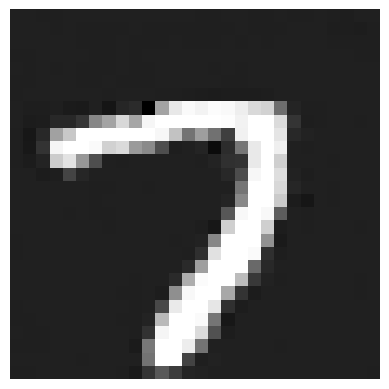

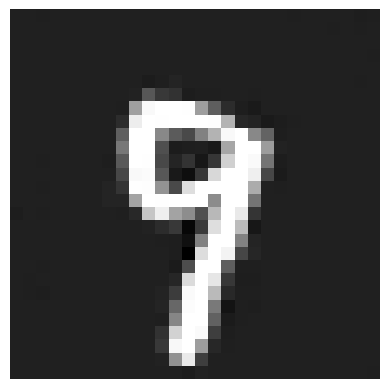

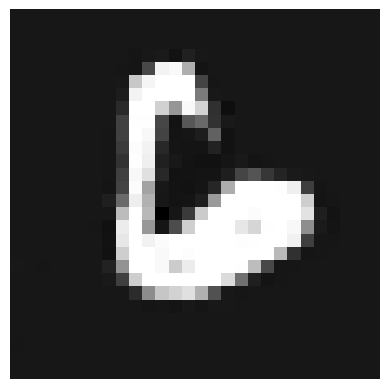

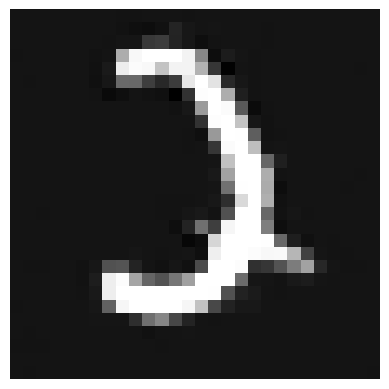

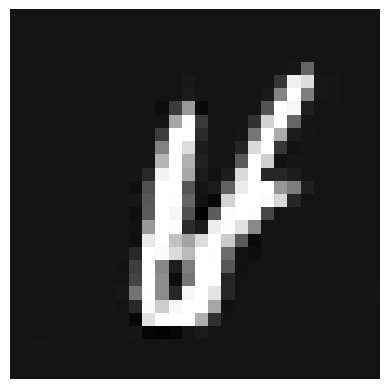

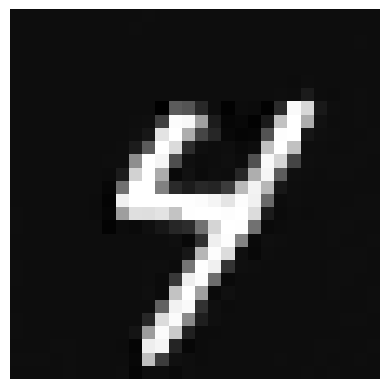

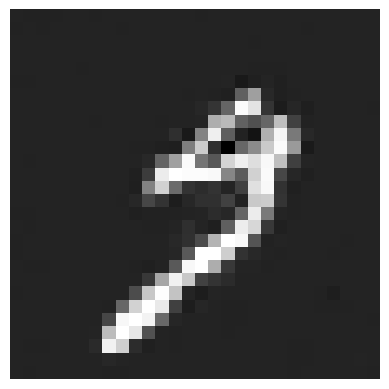

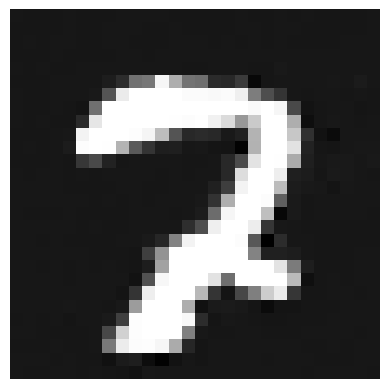

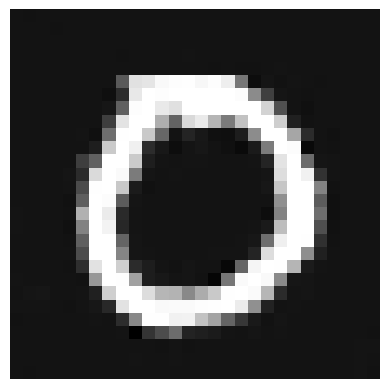

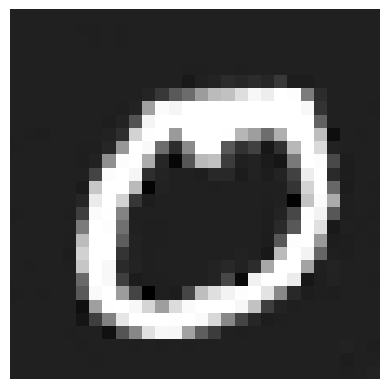

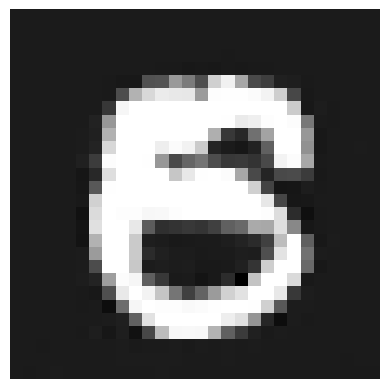

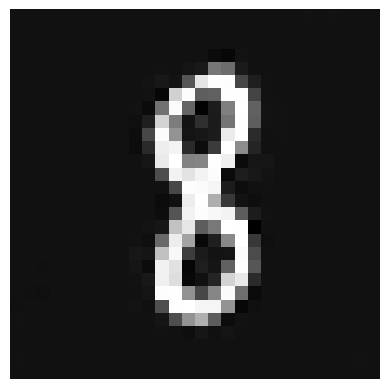

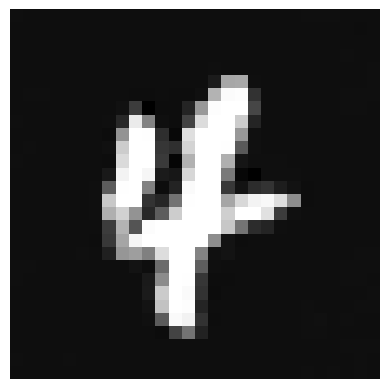

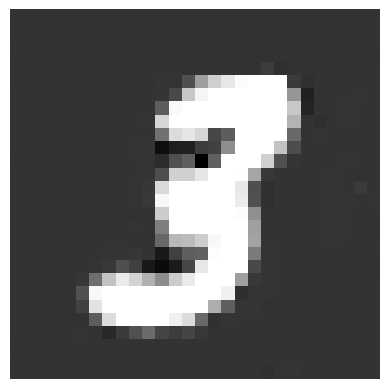

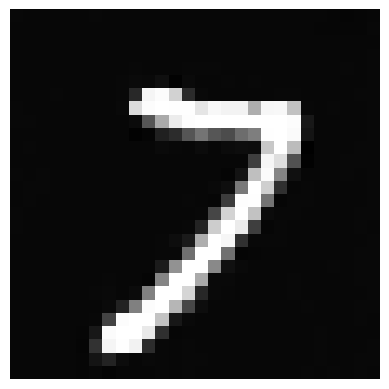

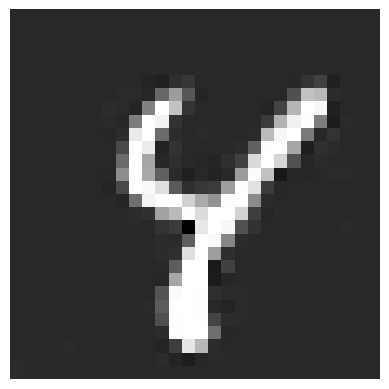

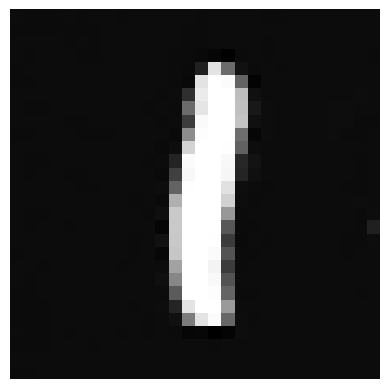

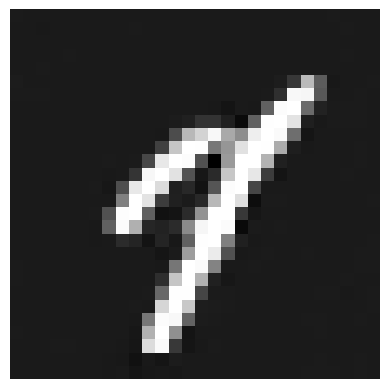

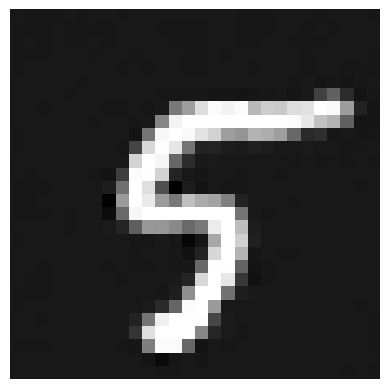

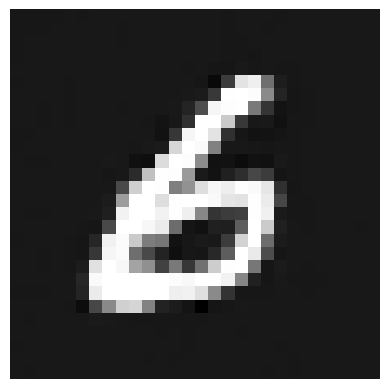

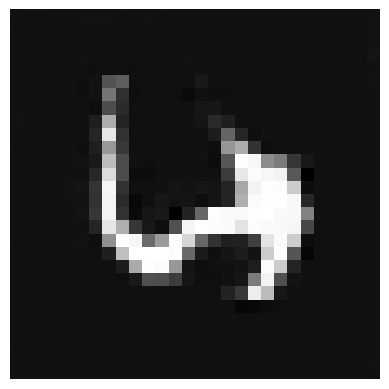

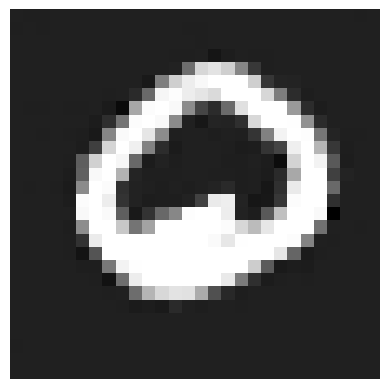

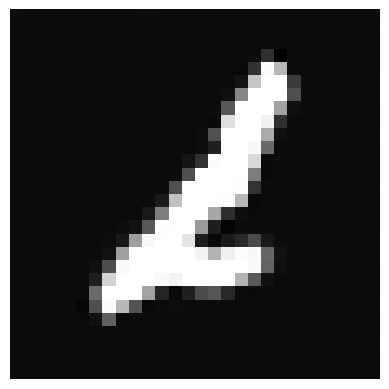

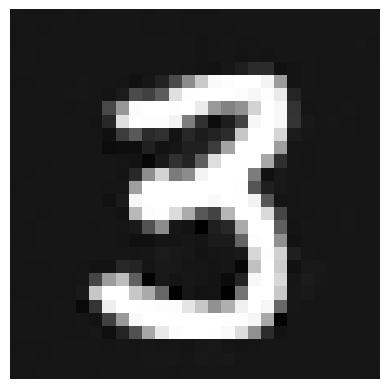

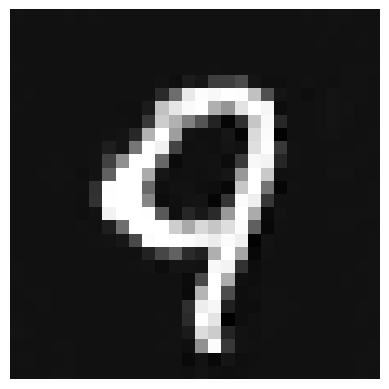

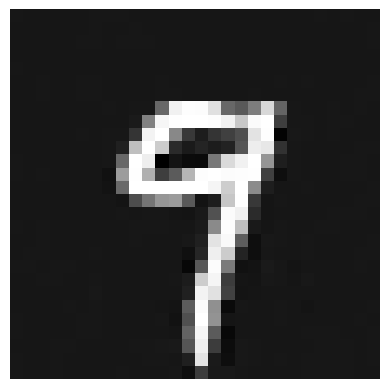

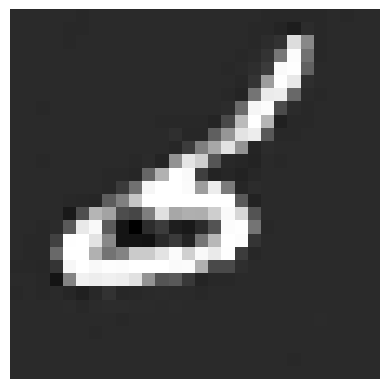

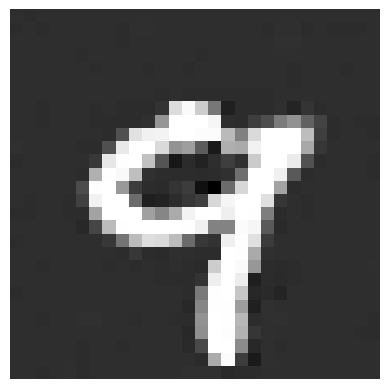

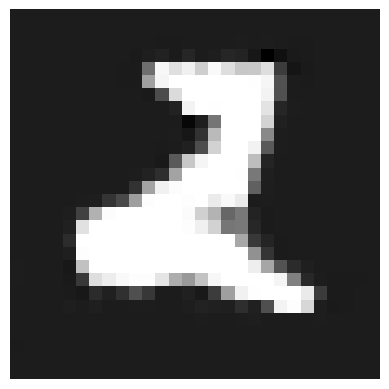

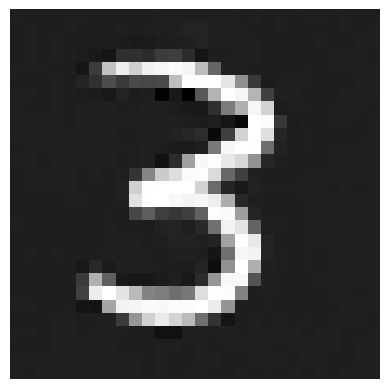

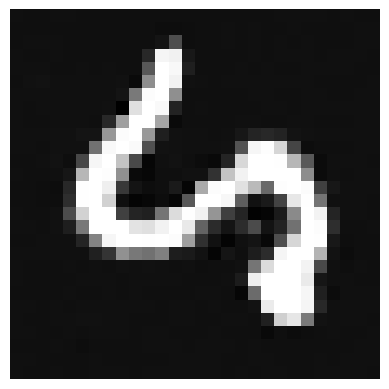

In [ ]:
generator.eval()
for _ in range(100):
    with torch.no_grad():
        fixed_noise = torch.randn(1, latent_dim, device=images.device)
        fake_img = generator(fixed_noise).detach().cpu()
        show_image(fake_img)